# Lab 7

In [82]:
import torch
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The Forward Forward algorithm

The [Forward Forward algorithm](https://www.cs.toronto.edu/~hinton/FFA13.pdf) has been presented by Geoffrey Hinton (one of the "Deep Learning godfathers") at NeurIPS 2022, less than a month ago.

It is a novel technique for Neural Network optimization, alternative to standard Backpropagation.

## An alternative to Backpropagation

Over the last decades, backprop has been so successful that neuroscientists have been looking for proofs that the brain actually learns in a similar way. However, that does not seem to happen. Moreover, backprop encounters serious limitations if the model is not exactly defined in mathematical terms: if the forward pass is a black box, there is no possibility to make a backward pass (as we don't know what to differentiate).

Even if (for the moment) it was not presented with the goal of substituting backprop for practical applications, the Forward Forward algorithm aims at solving some of these problems, using a layer-by-layer learning approach that does not require backward propagation of gradients.

## MNIST classification through FF

Let's see how FF works through a practical example on MNIST classification.

Citing the paper,  "the idea is to replace the forward and backward passes of backpropagation by two forward
passes that operate in exactly the same way as each other, but on different data and with opposite
objectives. The positive pass operates on real data and adjusts the weights to increase the goodness in
every hidden layer. The negative pass operates on "negative data" and adjusts the weights to decrease
the goodness in every hidden layer. This paper explores two different measures of goodness – the
sum of the squared neural activities and the negative sum of the squared activities, but many other
measures are possible."

Thus, we have to find a way to define "positive" and "negative" data. If we want to classify MNIST, a data point being positive means that it somehow contains the right assignment of an image to its corresponding class. Hence, we can define a positive datapoint by embedding the right classification into the image and a negative datapoint by embedding a random classification. To do so, we can exploit the fact that there is a black frame around the digit, and we can use the top 10 pixels on the left to embed class information.

![](images/ff_mnist.png)

Then, the layers of the network are trained one at a time with the objective of assigning high activation values (high goodness) to positive points and low to negative ones. However, if there are many layers, it would be trivial for following layers to rely on the information coming from the previous ones (if the activations of layer $i$ are high, this drastically increases the probability that the activations of layer $i+1$ are high as well). To avoid this phenomenon and make layers learn different features, it is necessary to normalize the activation vector to have norm $1$.

At the end, at evaluation time, one can query the network with a certain image with all possible labels, and take the argmax of the goodnesses to obtain the prediction.

In [83]:
class Net(torch.nn.Module):

    def __init__(self, dimensions):
        super().__init__()
        self.layers = torch.nn.ModuleList([ReLULayer(dimensions[i], dimensions[i + 1]) for i in range(len(dimensions)-1)])
    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            x_lab = label_images(x, label)
            goodness = []
            for i, layer in enumerate(self.layers):
                x_lab = layer(x_lab)
                if i>0:
                    goodness.append( ##################
                        torch.sum(torch.square(x_lab),dim=1)
                    )
            goodness_per_label.append(sum(goodness).unsqueeze(1))
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return torch.argmax(goodness_per_label, dim=1)
    
    def train(self, x_pos, x_neg):
        for layer in self.layers:
            x_pos, x_neg = layer.train(x_pos, x_neg)

In [84]:
def normalize(x): ###########
    return torch.nn.functional.normalize(x)

class ReLULayer(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = torch.nn.Linear(in_features, out_features)
        self.relu = torch.nn.ReLU()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0
        self.num_epochs = 1000

    def forward(self, x):
        x_direction = normalize(x)
        return self.relu(self.linear(x_direction))

    def train(self, x_pos, x_neg):
        for i in range(self.num_epochs):
            positive_goodness = torch.sum(torch.square(self.forward(x_pos)),dim=1) ####################
            negative_goodness = -torch.sum(torch.square(self.forward(x_neg)),dim=1)####################
            l = torch.log(1 + torch.exp(torch.cat([
                -positive_goodness + self.threshold,
                negative_goodness - self.threshold]))).mean()
            self.optimizer.zero_grad()
            l.backward()
            self.optimizer.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

In [85]:
torch.manual_seed(0)

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,)), torchvision.transforms.Lambda(torch.flatten)])

trainset = torchvision.datasets.MNIST('./data/', transform=transform,  train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=60000, shuffle=True)

testset = torchvision.datasets.MNIST('./data/', transform=transform, train=False, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False)

def label_images(images, labels):
    #this function takes shape (batch_size, 784) images and shape (batch_size) labels and returns label-embedded images, with shape (batch_size, 784)
    max_value = torch.max(images)
    images = images.reshape(-1,784).clone()
    for i, image in enumerate(images):
        label = labels if type(labels) == int else labels[i]
        image[label] = max_value
    return images

net = Net([784, 500, 500]).to(device)
x, y = next(iter(trainloader))
x=x.to(device)
y=y.to(device)
x_pos = label_images(x, y)
rnd = torch.randperm(x.size(0))

x_neg = label_images(x, y[rnd])
net.train(x_pos, x_neg)

print('Train accuracy:', net.predict(x).eq(y).float().mean().item())

x_te, y_te = next(iter(testloader))
x_te=x_te.to(device)
y_te=y_te.to(device)

print('Test accuracy:', net.predict(x_te).eq(y_te).float().mean().item())

Train accuracy: 0.0026666666381061077
Test accuracy: 0.002099999925121665


In [55]:
x,y = next(iter(trainloader))

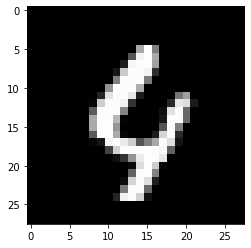

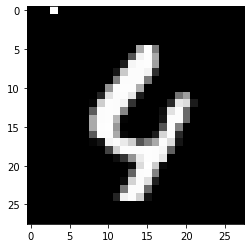

In [58]:
def display_images(input, output):
    if input is not None:
        input_pics = input.data.cpu().numpy().reshape(28,28)
        plt.imshow(input_pics,cmap='gray')
    plt.figure(figsize=(18, 4))
    output_pics = output.data.cpu().numpy().reshape(28,28)
    plt.imshow(output_pics,cmap='gray')

index = 3
number = 3
display_images(x[index].reshape(-1,784),label_images(x[index].reshape(-1,784),number))

In [80]:
model = ReLULayer(784,500)
x = torch.rand(4,784)

In [81]:
print(torch.sum(torch.square(model.forward(x)),dim=1))
print(torch.sum(torch.square(model(x)),dim=1) )

tensor([0.2283, 0.2297, 0.2190, 0.2363], grad_fn=<SumBackward1>)
tensor([0.2283, 0.2297, 0.2190, 0.2363], grad_fn=<SumBackward1>)


# Third assignment (deadline 8 January)



1.   Read Hinton's [paper](https://www.cs.toronto.edu/~hinton/FFA13.pdf) about the Forward Forward algorithm. In particular, pay attention to the first 6/7 pages of it.
2.   Fill the gaps in the notebook to reproduce the experiment described at page 5 of the paper.
3.   Experiment with two of the following three points for future work reported in the paper and discuss your findings:
    *   Can the positive and negative passes be very widely separated in time as they would be if
the negative passes were done during sleep?
    *   What is the best goodness function to use?
    *   What is the best activation function to use? 

You can send your work as a jupyter notebook in any format you prefer (`ipynb`, `pdf` or `html`) to lore.basile@outlook.com by 23.59, 08/01/2023. Please name the file as `NameSurname.<format>`.

For any doubt do not hesitate to reach out at alessio.ansuini@areasciencepark.it and lore.basile@outlook.com.

